In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.optimize as opt
from __future__ import division

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
def gen_arma(ar=[], ma=[], N=1000, mu=0):
    
    p, q = map(len, [ar, ma])
    ar, ma = map(np.array, [ar[::-1], ma[::-1]])
    
    max_order = max(p, q)
    
    wn = np.random.normal(0, 1, N + max_order)
    ts = np.zeros(N + max_order)
    
    for i in range(N):
        
        idx = i + max_order
        ts[idx] = mu + wn[idx] + np.dot(ts[idx - p:idx], ar) + np.dot(wn[idx - q:idx], ma)
    
    return ts[max_order:]

## Q1

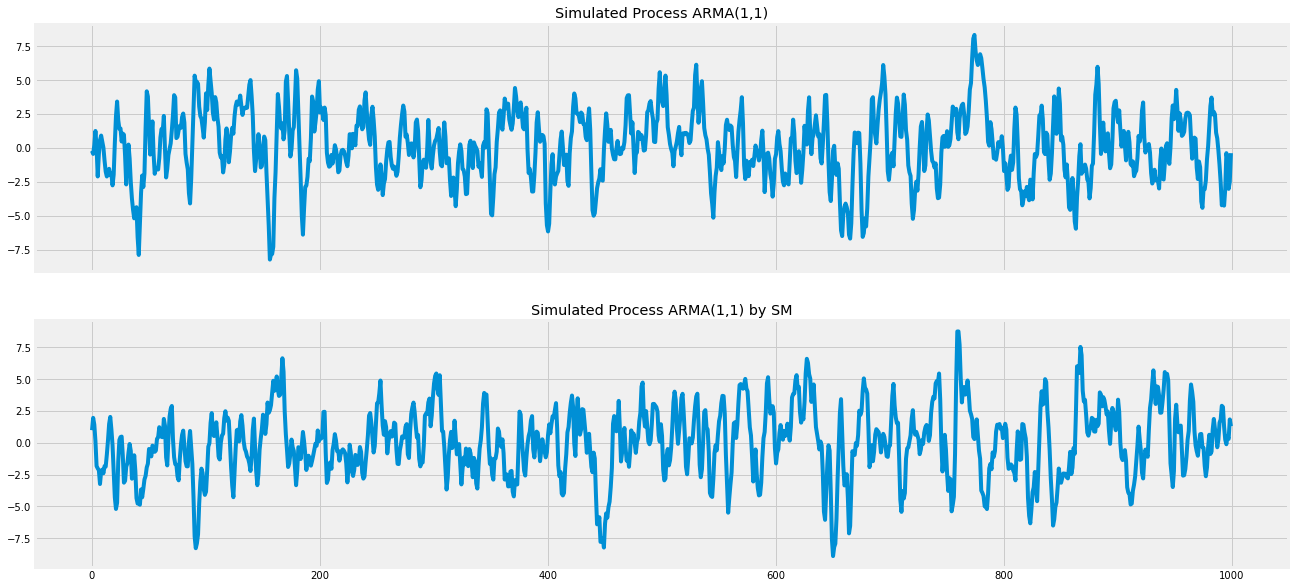

In [3]:
T = 1000
ar_coef = [0.8]
ma_coef = [0.7]

y_jc = gen_arma(ar_coef, ma_coef, T)
y_sm = sm.tsa.ArmaProcess(-np.array([-1] + ar_coef), [1] + ma_coef).generate_sample(T)

fig, ax = plt.subplots(2,1, sharex=True, figsize=(20,10))
ax[0].plot(range(T), y_jc)
ax[1].plot(range(T), y_sm)

ax[0].set_title('Simulated Process ARMA(1,1)')
ax[1].set_title('Simulated Process ARMA(1,1) by SM')

In [4]:
def OLS(Y, X, const=True):
    Y = np.array(Y)
    X = np.c_[np.ones(np.shape(Y)),np.array(X)] if const else np.array(X)
    
    cov = np.dot(np.transpose(X),Y)
    var = np.dot(np.transpose(X),X)
    
    b = np.dot(np.linalg.inv(var), cov)
    return b if b.shape!=(1,1) else float(b)

def AR_data_preprocess(TS, ar_lag=1):
    
    Y = np.array(TS[ar_lag:])
    Y = Y.reshape(len(Y),1)
    X = np.r_[map(lambda i: TS[ar_lag-i-1:-i-1], range(ar_lag))].T
    
    return Y, X

In [5]:
def get_IV_est(Y):
    
    y, x = AR_data_preprocess(Y, 2)
    z = x[:,1]
    x = x[:,0]   
    return float(z.T.dot(y) / z.T.dot(x))

def get_OLS_est(Y):
    
    y, X = AR_data_preprocess(Y, 1)
    return OLS(y, X, False)

In [6]:
num_of_est = 10000

estimate = map(lambda s: (get_OLS_est(s), get_IV_est(s)), \
               [gen_arma(ar_coef, ma_coef, T) for i in range(num_of_est)])
estimate_OLS = [e[0] for e in estimate]
estimate_IV = [e[1] for e in estimate]

Mean of phi: 0.895946699426
SD of phi: 0.0104346425299


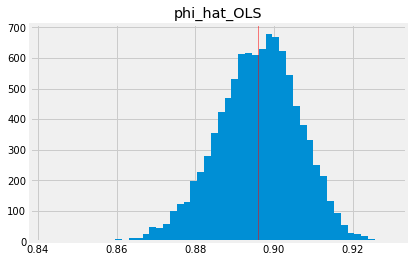

In [7]:
m_OLS = np.mean(estimate_OLS)

print 'Mean of phi:', m_OLS
print 'SD of phi:', np.std(estimate_OLS)
    
plt.hist(estimate_OLS, bins=50)
plt.axvline(m_OLS, linewidth=0.5, color='r')
plt.title('phi_hat_OLS')

Mean of phi: 0.798178834516
SD of phi: 0.0220106801435


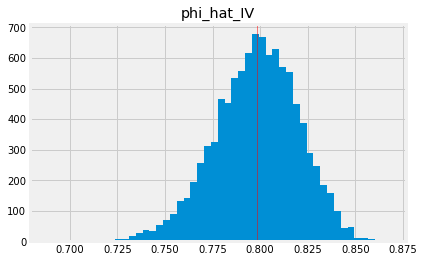

In [8]:
m_IV = np.mean(estimate_IV)

print 'Mean of phi:', m_IV
print 'SD of phi:', np.std(estimate_IV)
    
plt.hist(estimate_IV, bins=50)
plt.axvline(m_IV, linewidth=0.5, color='r')
plt.title('phi_hat_IV')

### Test with statsmodels

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1603.199
Method:                       css-mle   S.D. of innovations              1.201
Date:                Thu, 20 Apr 2017   AIC                           3210.399
Time:                        19:35:51   BIC                           3220.214
Sample:                             0   HQIC                          3214.129
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.y        0.8799      0.015     58.977      0.000         0.851     0.909
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1365           +0.0000j            1.1365            0.0000
-----------------------------------------------------------------------------
"""

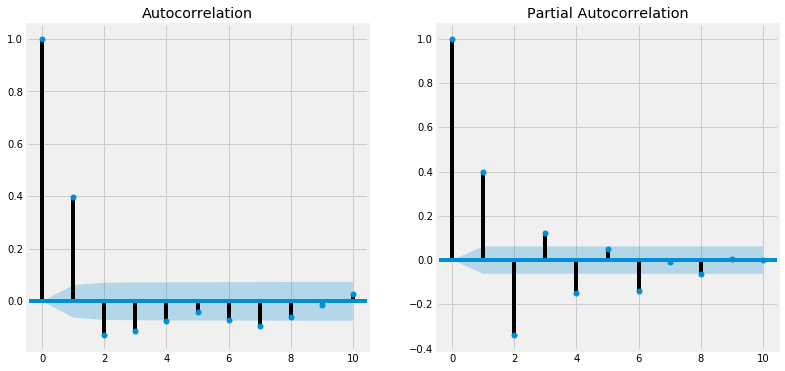

In [9]:
arma_model = sm.tsa.ARMA(y_jc, order=(1,0))

ests = arma_model.fit(maxiter=500, trend='nc')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sm.tsa.graphics.plot_acf(ests.resid, lags=10, ax=axes[0])
sm.tsa.graphics.plot_pacf(ests.resid, lags=10, ax=axes[1])
ests.summary()

## Q4

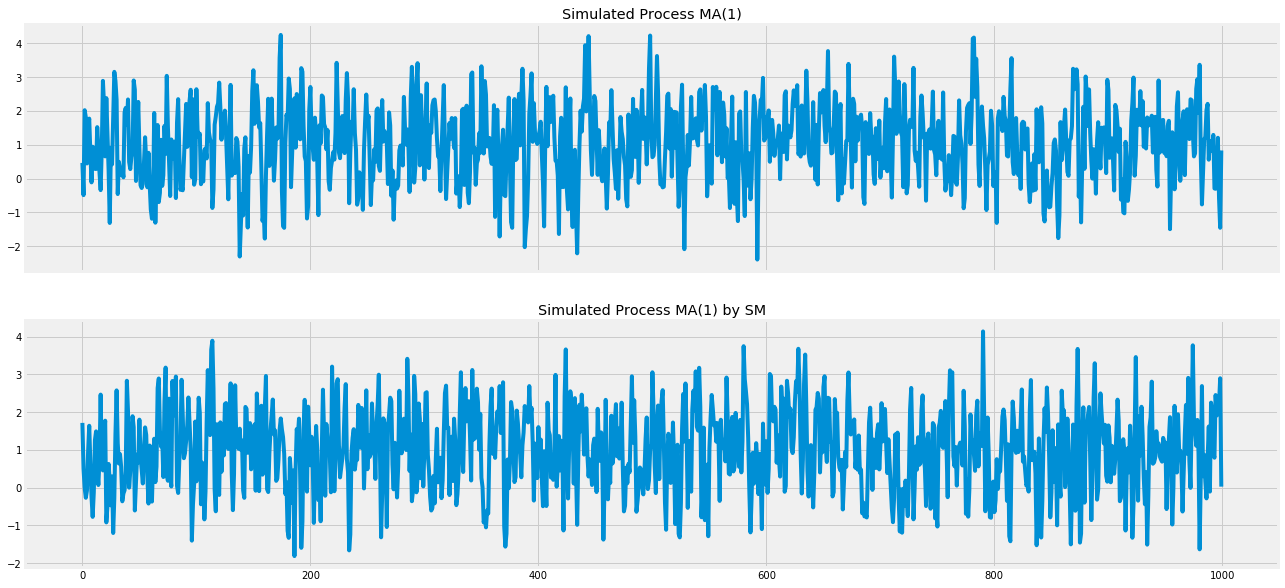

In [10]:
T = 1000
ar_coef = [0]
ma_coef = [0.5]

y_jc = gen_arma(ar_coef, ma_coef, T, 1)
y_sm = sm.tsa.ArmaProcess(-np.array([-1] + ar_coef), [1] + ma_coef).generate_sample(T) + 1

fig, ax = plt.subplots(2,1, sharex=True, figsize=(20,10))
ax[0].plot(range(T), y_jc)
ax[1].plot(range(T), y_sm)

ax[0].set_title('Simulated Process MA(1)')
ax[1].set_title('Simulated Process MA(1) by SM')

In [11]:
def transform_ts_to_error(ts, mu, psi):
    T = len(ts)
    e = ts - mu
    for t in range(T - 1):
        e[t + 1] -= psi * e[t]
    
    return e

def LogLikelihood(ts, mu, psi, sd):
    
    v = sd * sd
    T = len(ts)
    e = transform_ts_to_error(ts, mu, psi)
    sse = e.T.dot(e)
    
    return float(-T / 2 * (np.log(2 * np.pi * v)) - sse / (2 * v))

In [12]:
min_object = lambda THETA: - LogLikelihood(y_jc, THETA[0], THETA[1], THETA[2])
res = opt.minimize(min_object, (0,1,1))
my_theta = res.x
print 'mu: %.4f\npsi: %.4f\nsigma: %.4f'% tuple(my_theta)

mu: 1.0497
psi: 0.4873
sigma: 1.0146


In [13]:
def info_matrix(y, theta, e, f=LogLikelihood):
    
    L = lambda t: f(y, t[0,0], t[0,1], t[0,2])
    n = len(theta)
    H = np.zeros((n, n))
    theta = theta.reshape(1, n)
    
    for i in range(n):
        for j in range(n):
            if i==j:
                t_p = theta + np.eye(1, n, i) * e
                t_m = theta - np.eye(1, n, i) * e
                H[i, j] = (L(t_p) + L(t_m) - 2*L(theta)) / (e*e)
            else:
                t_i = theta + np.eye(1, n, i) * e
                t_j = theta + np.eye(1, n, j) * e
                t_ij = theta + (np.eye(1, n, i) + np.eye(1, n, j)) * e
                H[i, j] = (L(t_ij) - L(t_i) - L(t_j) + L(theta)) / (e*e)
    
    return -H / len(y)

I = info_matrix(y_jc, my_theta, 0.001)
print I

[[  4.39581691e-01  -1.79360291e-03  -4.32607976e-04]
 [ -1.79360291e-03   1.37548836e+00  -1.35535583e-03]
 [ -4.32607976e-04  -1.35535583e-03   1.94277001e+00]]


In [14]:
V = np.linalg.inv(I)
print 'SD of parameters:\nmu: %.4f\npsi: %.4f\nsigma: %.4f' %tuple(np.sqrt(V.diagonal() / T))

SD of parameters:
mu: 0.0477
psi: 0.0270
sigma: 0.0227


### Test with statsmodels

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1433.580
Method:                       css-mle   S.D. of innovations              1.015
Date:                Thu, 20 Apr 2017   AIC                           2873.161
Time:                        19:35:52   BIC                           2887.884
Sample:                             0   HQIC                          2878.757
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.0495      0.048     22.007      0.000         0.956     1.143
ma.L1.y        0.4869      0.027     18.047      0.000         0.434     0.540
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.0537           +0.0000j            2.0537            0.5000
-----------------------------------------------------------------------------
"""

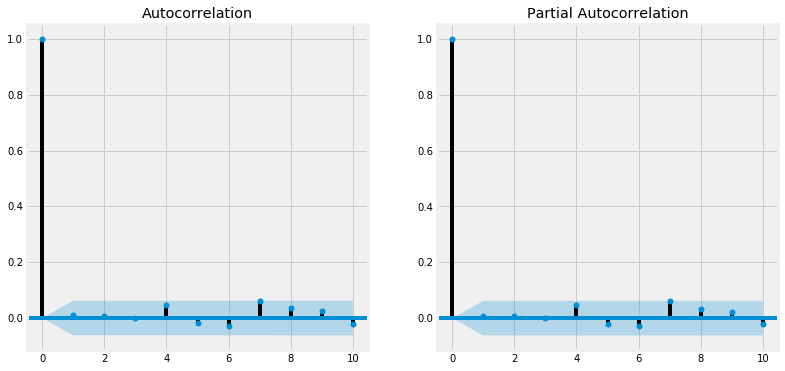

In [15]:
arma_model = sm.tsa.ARMA(y_jc, order=(0,1))

ests = arma_model.fit(maxiter=500, trend='c')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sm.tsa.graphics.plot_acf(ests.resid, lags=10, ax=axes[0])
sm.tsa.graphics.plot_pacf(ests.resid, lags=10, ax=axes[1])
ests.summary()